#### Name: Tran Dinh Gia Khanh - 20020141 - INT3406E_41

# Programming Assignment 1 Report

# Data Processing

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## w2v

In [3]:
w2v_df = pd.read_table('./W2V_150.txt', sep="  ", skiprows=2, header=None)
w2v_df.columns = ["word", "vec"]
w2v_df.head(5)
X = []
for i in range(w2v_df.shape[0]):
    word_vec = []
    vec = str(w2v_df["vec"].values[i]).split()
    for v in vec:
        word_vec.append(float(v))
    X.append(word_vec)

C:\Users\DELL\AppData\Local\Temp\ipykernel_18624\1469312843.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  w2v_df = pd.read_table('./W2V_150.txt', sep="  ", skiprows=2, header=None)


### Glove Model

In [4]:
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

w2v_model = KeyedVectors.load_word2vec_format("W2V_150_2.txt", no_header=True, binary=False)

In [5]:
print(w2v_model.distance('hệ_điều_hành','đồng_cỏ'))
print(w2v_model.distance('hệ_điều_hành','máy_vi_tính'))
print(w2v_model.distance('hệ_điều_hành','không_thay_đổi'))

0.8560910075902939
0.809864342212677
1.0064395498484373


In [6]:
w2v_model.similar_by_word('sinh_viên')

[('sv', 0.7981585264205933),
 ('du_học_sinh', 0.678442120552063),
 ('hs-sv', 0.6702901721000671),
 ('học_viên', 0.6616679430007935),
 ('lưu_học_sinh', 0.6281952857971191),
 ('giảng_viên', 0.60367751121521),
 ('học_sinh', 0.5898551344871521),
 ('nghiên_cứu_sinh', 0.5815644264221191),
 ('giáo_viên', 0.568815290927887),
 ('nam_sinh', 0.5621474981307983)]

In [7]:
w2v_model.most_similar_cosmul(positive=['một_màu','xanh'],negative=['đỏ'])

[('xanh_lam', 0.8765115737915039),
 ('sơn_màu', 0.8756780028343201),
 ('sự_nổi_bật', 0.8618715405464172),
 ('có_mầu', 0.861246645450592),
 ('tông_màu', 0.8576458096504211),
 ('thoang_thoảng', 0.839997410774231),
 ('sự_mộc_mạc', 0.8358392119407654),
 ('xanh_lá_cây', 0.8280478119850159),
 ('đỏ_đậm', 0.823334276676178),
 ('màu', 0.8232325911521912)]

# 1. Cosine similarity

*From sklearn library*

In [8]:
from sklearn.metrics.pairwise import cosine_similarity as cos_sim

In [9]:
print(cos_sim([[i for i in (w2v_model.get_vector('lỗ_đen'))]],[X[w2v_model.get_index('hố_đen')]]))
print(cos_sim([[i for i in (w2v_model.get_vector('xanh'))]],[X[w2v_model.get_index('đỏ')]]))
# print([[i for i in (w2v_model.get_vector('xanh'))]])

[[0.73406833]]
[[0.64127283]]


**Calculate cosine similarity**

In [10]:
def cal_cos_sim(x,y):
    num = np.dot(x,y) 
    denom = np.sqrt(np.sum(np.power(x,2))*np.sum(np.power(y,2)))
    return(num/denom)

High similarity

In [11]:
print(cal_cos_sim((w2v_model.get_vector('lỗ_đen')),(w2v_model.get_vector('hố_đen'))))
print(cal_cos_sim((w2v_model.get_vector('xanh')),(w2v_model.get_vector('đỏ'))))

0.73406833
0.6412728


Low similarity

In [12]:
print(cal_cos_sim((w2v_model.get_vector('nan')),(w2v_model.get_vector('được_tôn_trọng'))))
print(cal_cos_sim((w2v_model.get_vector('xanh')),(w2v_model.get_vector('ma_chay'))))

-0.2847676
-0.27114934


In [13]:
def cal_cos_sim_word(word1, word2):
    word1 = str(word1)
    word2 = str(word2)
    if not w2v_model.has_index_for(word1) or not w2v_model.has_index_for(word2):
        return -1
    return cal_cos_sim((w2v_model.get_vector(str(word1))),(w2v_model.get_vector(str(word2))))

## ViSim-400

In [14]:
visim_df = pd.read_table('./Visim-400.txt', sep='\t')
visim_y = visim_df["STD"].values

In [15]:
y_pred = []
threshold = 0.75
hit = 0
for i in range(visim_df.__len__()):
    y_pred.append(cal_cos_sim_word(visim_df["Word1"].values[i],visim_df["Word2"].values[i]))
# print(visim_y)
# print(y_pred)
# print(len(y_pred))
for i in range(len(y_pred)):
    hit += 1 if ((y_pred[i] >= threshold and visim_y[i] >= threshold) or (y_pred[i] < threshold and visim_y[i] < threshold)) else 0
print(y_pred.count(-1)/len(y_pred))
print(hit/len(y_pred))

0.14
0.31


# 2. K Nearest

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from itertools import islice

Calculate k nearest words: find k most-similar words

In [17]:
def k_nearest(word, k):
    print(word, k)
    res = []
    # print((w2v_df["word"]))
    for w in w2v_df["word"]:
        sim_val = cal_cos_sim((w2v_model.get_vector(str(word))),(w2v_model.get_vector(str(w))))
        # print(w,sim_val)
        res.append((sim_val,str(w)))
    res = sorted(res, reverse=True)
    return res[1:k+1]

k_nearest('lỗ_đen',5)

lỗ_đen 5


[(0.73406833, 'hố_đen'),
 (0.6743552, 'thiên_thể'),
 (0.62004215, 'photon'),
 (0.60821897, 'hành_tinh'),
 (0.6032495, 'vũ_trụ')]

10 nearest words of 'xanh'

In [18]:
k_nearest('xanh',10)

xanh 10


[(0.6412728, 'đỏ'),
 (0.5846398, 'xanh_lục'),
 (0.5595949, 'sẫm'),
 (0.53329074, 'xanh_biếc'),
 (0.5305078, 'màu_đỏ'),
 (0.52797484, 'trắng'),
 (0.5248693, 'đỏ_sẫm'),
 (0.5110781, 'trắng_trong'),
 (0.501482, 'xanh_da_trời'),
 (0.49207163, 'xanh_ngắt')]

In [19]:
def k_furthest(word, k):
    # print(word, k)
    res = []
    # print((w2v_df["word"]))
    for w in w2v_df["word"]:
        sim_val = cal_cos_sim((w2v_model.get_vector(str(word))),(w2v_model.get_vector(str(w))))
        # print(w,sim_val)
        res.append((sim_val,str(w)))
    res = sorted(res)
    return res[0:k]

# 3. Synonym-antonym classification

## Data Processing

### Synonym

In [20]:
syn_df = pd.read_csv('./antonym-synonym set/Synonym_vietnamese.txt',sep=' ', header=None)
syn_df.columns = ["Word1", "Word2"]
syn_df.head(5)

,Word1,Word2
0,a_dua,a_tòng
1,a_dua,vào_hùa
2,a_ma_tơ,tài_tử
3,a_tòng,vào_hùa
4,à_ơi,ạ_ơi


In [21]:
y_pred_syn = [cal_cos_sim_word(syn_df["Word1"].values[i], syn_df["Word2"].values[i]) for i in range(syn_df.__len__())]
y_pred_syn.count(-1)/len(y_pred_syn)

0.4571008476042207

45% synonym words are not in w2v file

### Antonym

In [22]:
ant_df = pd.read_csv('./antonym-synonym set/Antonym_vietnamese.txt',sep=' ', header=None)
ant_df.columns = ["Word1", "Word2"]
ant_df.head(5)

,Word1,Word2
0,ác,hiền
1,ác,thiện
2,ác_cảm,thiện_cảm
3,ác_độc,hiền_lành
4,ác_độc,hiền_từ


In [23]:
y_pred_ant = [cal_cos_sim_word(ant_df["Word1"].values[i], ant_df["Word2"].values[i]) for i in range(ant_df.__len__())]
y_pred_ant.count(-1)/len(y_pred_ant)

0.1345

13% antonym words are not in w2v file 

## Scoring

Precision Score

In [24]:
def precision_score(y_pred, y_true):
    true_pos = 0
    false_pos = 0
    for i in range(y_true.__len__()):
        if (y_pred[i] == y_true[i] == 1):
            true_pos += 1
        elif (y_true[i] == 0 and y_pred[i] == 1):
            false_pos += 1
    return true_pos/(true_pos + false_pos)

Recall Score

In [25]:
def recall_score(y_pred, y_true):
    true_pos = 0
    false_neg = 0
    for i in range(y_true.__len__()):
        if (y_pred[i] == y_true[i] == 1):
            true_pos += 1
        elif (y_true[i] == 1 and y_pred[i] == 0):
            false_neg += 1
    return true_pos/(true_pos + false_neg)

F1 Score

In [26]:
def f1_score(y_pred, y_true):
    pre = precision_score(y_pred, y_true)
    rec = recall_score(y_pred, y_true)
    return 2 * (pre * rec) / (pre + rec)

Accuracy

In [27]:
def accuracy_score(y_pred, y_true):
    true_pos = 0
    true_neg = 0
    for i in range(y_true.__len__()):
        if (y_pred[i] == y_true[i] == 1):
            true_pos += 1
        elif (y_true[i] == 0 and y_pred[i] == 0):
            true_neg += 1
    return (true_pos + true_neg) / y_true.__len__()

## Train

### Using GridCV with LinearRegression model
```GridCV``` allows cross validation, where dataset is splitted into portions. ```GridCV``` uses K-fold split, where the model take ```1``` part of dataset and cross validate it on ```k-1``` part of the data.

```Logistic Regression``` is used to classify the data. ```SYN``` is represented by ```1``` and ```ANT``` is by ```0```.

<!-- The [model](#training-model) is here. -->

In [28]:
X_train = []
y_train = []
for i in range(syn_df.__len__()):
    if(w2v_model.has_index_for(syn_df["Word1"].values[i]) and w2v_model.has_index_for(syn_df["Word2"].values[i])):
        # X_train.append(np.append(w2v_model.get_vector(syn_df["Word1"].values[i]) - [w2v_model.get_index(syn_df["Word2"].values[i]), cal_cos_sim_word(syn_df["Word1"].values[i],syn_df["Word2"].values[i])]))
        word1 = syn_df["Word1"].values[i]
        word2 = syn_df["Word2"].values[i]
        data = np.append(((np.matrix(w2v_model.get_vector(word1)) - np.matrix(w2v_model.get_vector(word2))).A1), [cal_cos_sim_word(word1,word2), w2v_model.distance(word1,word2)])
        X_train.append(data)
        y_train.append(1)


for i in range(ant_df.__len__()):
    if(w2v_model.has_index_for(ant_df["Word1"].values[i]) and w2v_model.has_index_for(ant_df["Word2"].values[i])):
        word1 = ant_df["Word1"].values[i]
        word2 = ant_df["Word2"].values[i]
        data = np.append(((np.matrix(w2v_model.get_vector(word1)) - np.matrix(w2v_model.get_vector(word2))).A1), [cal_cos_sim_word(word1,word2), w2v_model.distance(word1,word2)])
        X_train.append(data)
        y_train.append(0)

Shuffle training set

In [29]:
pd.DataFrame(X_train,y_train)

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,150,151
1,-0.928218,-0.385185,1.777838,1.890072,-0.802963,-2.973950,-0.213209,-0.401988,-1.205294,-1.870895,...,-0.233732,-0.553111,0.829941,-1.700927,0.258158,-0.207574,1.343269,0.335742,0.288864,0.711136
1,0.178174,2.569418,0.293047,1.955840,1.431875,0.817188,-3.124852,-3.800794,0.733388,-0.396096,...,5.413120,1.231402,-0.436597,-1.410038,0.550121,-0.026403,-1.290711,0.421264,0.274868,0.725132
1,0.080156,-0.560429,0.337595,0.229531,-0.583598,0.633597,-0.354038,1.222823,0.539413,0.924671,...,-1.498061,-0.211129,-0.724569,1.848196,1.158185,-0.237788,0.124224,1.078634,0.689217,0.310783
1,2.115030,0.433743,-1.358720,-1.330174,-0.408713,0.869569,-1.528072,2.108073,-0.026265,-0.169240,...,0.911754,-0.696353,-0.576246,0.433402,0.794702,0.985866,0.374873,0.023481,0.442920,0.557080
1,-1.282248,-0.965640,0.450324,0.873514,-2.832006,1.457322,-0.959311,0.066183,2.076099,1.417614,...,0.118243,-2.507002,1.453930,1.968888,-0.876063,0.181683,0.152052,0.000007,0.591152,0.408848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-2.009850,3.685195,-0.451190,1.505435,3.969727,0.908700,1.243413,-0.211787,1.549414,-0.952503,...,-0.690106,-0.480092,-0.726254,-1.101084,-1.483378,0.314636,-0.274222,0.472368,0.383018,0.616982
0,0.256957,1.926512,-1.484244,2.227939,-1.283928,-0.904757,3.006973,-1.323795,1.945335,-1.043332,...,-0.533479,1.437025,0.681311,0.350230,-0.316768,0.493050,-1.510988,0.165869,0.471292,0.528708
0,-0.365065,3.659172,-2.171290,1.949037,-0.478396,1.669334,1.345654,-0.413369,1.022013,-1.476738,...,0.210175,1.122025,0.830070,1.801573,-0.936432,-0.813998,-1.684868,0.177833,0.446969,0.553031
0,0.053572,2.666481,-0.028208,1.563359,-1.257315,2.266086,2.835695,0.771760,2.494303,-0.854036,...,-0.977193,0.757703,1.973597,1.103312,-0.663029,-2.508402,-2.018607,-1.180644,0.479427,0.520573


In [30]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train,y_train, random_state = 0)

In [31]:
pd.DataFrame(X_train,y_train)

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,150,151
1,-0.733735,1.797300,-1.320114,-1.790933,-0.303699,1.079478,1.548357,-0.722256,-1.608632,0.273579,...,0.650019,1.219048,0.116208,0.517957,-0.030667,-0.944132,-0.314809,0.373490,0.227997,0.772003
1,-0.290836,1.401782,-0.716173,-1.121370,0.112931,-0.010578,0.251863,2.373153,0.442569,-1.689692,...,0.452755,-1.982042,0.833483,-1.816964,-0.195082,-0.973719,-1.632419,2.279999,0.437601,0.562399
1,2.709668,-0.388378,0.101671,0.683128,-0.061657,0.098064,-0.341945,-0.093155,-0.110636,0.805922,...,-0.783508,1.828357,0.630363,2.098143,0.028243,-0.301803,0.380209,0.616658,0.592245,0.407755
1,-2.047765,-3.656027,0.728025,-1.411729,0.938142,-1.584644,0.800611,2.838365,-0.247079,1.377212,...,1.834784,-1.880602,1.725105,0.830488,-3.578620,-1.523229,1.760037,0.568448,0.071697,0.928303
1,0.295622,0.075187,-0.362076,-0.597050,0.265346,-0.006536,0.992311,-0.246451,-0.908586,-0.602080,...,0.311498,-0.821235,-0.903845,0.639025,2.089021,1.827549,0.644193,0.514836,0.456468,0.543532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.871412,-0.026606,-4.750921,0.981890,2.840273,1.372901,1.913212,-1.797146,0.284190,-0.295446,...,-1.174757,-0.817868,2.928297,1.811674,2.594019,1.611194,-0.435955,0.502361,0.170591,0.829409
1,1.003751,-0.382406,-1.126672,0.455646,-0.507016,-1.315747,-0.705447,-0.662420,1.243054,-0.394131,...,0.807438,-0.336655,-1.890008,0.806446,1.193509,-0.216587,-1.191279,0.097646,0.477852,0.522148
1,1.213385,-0.565838,-0.423685,-2.597935,-0.208179,-0.671114,-1.262068,-0.511741,-1.726514,1.517158,...,-0.982464,2.384979,0.184239,2.455589,1.041312,-2.130186,2.339277,1.926712,0.046975,0.953025
1,-1.150224,-1.301633,1.039014,-1.900237,-0.871319,-0.088779,1.642935,0.270151,1.018297,-4.623357,...,2.161322,0.569177,0.523925,1.213911,-1.983692,-1.569323,1.856557,2.473937,0.072241,0.927759


### Training model

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [33]:
grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid = {'class_weight':[{0:3,1:1}]},
    cv = 10,
    n_jobs = -1,
    return_train_score=True,
)
grid.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 3, 1: 1}]},
             return_train_score=True)

In [34]:
def predict(word1, word2):
    # X = [np.append(w2v_model.get_vector(word1), [w2v_model.get_index(word2), cal_cos_sim_word(word1,word2)])]
    if(w2v_model.has_index_for(word1) and w2v_model.has_index_for(word2)):
        X = [np.append(((np.matrix(w2v_model.get_vector(word1)) - np.matrix(w2v_model.get_vector(word2))).A1), [cal_cos_sim_word(word1,word2), w2v_model.distance(word1,word2)])]
        return grid.predict(X)[0]
    else:
        return -1

In [35]:
word = 'xanh'
print(k_furthest(word,5))
print(k_nearest(word,5))

[(-0.27114934, 'ma_chay'), (-0.26909685, 'người_sử_dụng_thuốc'), (-0.26330557, 'tiết_giảm'), (-0.26200894, 'bệnh_viện_tâm_thần'), (-0.26136175, 'không_tính_được')]
xanh 5
[(0.6412728, 'đỏ'), (0.5846398, 'xanh_lục'), (0.5595949, 'sẫm'), (0.53329074, 'xanh_biếc'), (0.5305078, 'màu_đỏ')]


In [36]:
word = 'khéo'
print(predict(word,'vụng'))
print(predict(word,'vẻ'))

1
1


## Test

In [37]:
file_paths = ["./ViCon-400/400_noun_pairs.txt", "./ViCon-400/400_verb_pairs.txt", "./ViCon-400/600_adj_pairs.txt"]

In [38]:
# grid = GridSearchCV(
#     estimator=LogisticRegression(max_iter=1000),
#     # param_grid = {'class_weight':[{0:v,1:1} for v in range(1,20)]},
#     param_grid = {'class_weight':[{0:3,1:1}]},
#     cv = 10,
#     n_jobs = -1,
#     return_train_score=True,
# )
# grid.fit(X_train,y_train)

In [61]:
unknown = 0
total_words = 0
for path in file_paths:
    df = pd.read_csv(path,sep='\t')
    y_test = []
    y_pred = []
    for rel in df["Relation"].values:
        y_test.append(1 if rel == "SYN" else 0)
    for i in range(df["Relation"].__len__()):
        y_pred.append(predict(df["Word1"].values[i],df["Word2"].values[i]))
        # print(i) if y_pred[i] != y_test[i] else None
    print(df.head(4))
    # print(np.array(y_test))
    # print(np.array(y_pred))
    print('precision_score:',precision_score(y_pred, y_test))
    print('recall_score:',recall_score(y_pred, y_test))
    print('f1_score:',f1_score(y_pred, y_test))
    print('accuracy_score:',accuracy_score(y_pred, y_test))
    unknown += y_pred.count(-1)
    total_words += df.shape[0]

        Word1     Word2 Relation
0   khoái_lạc   nỗi_đau      ANT
1     yếu_kém  sức_mạnh      ANT
2  thanh_danh    ô_nhục      ANT
3         dây       dọc      SYN
precision_score: 0.6594594594594595
recall_score: 0.7922077922077922
f1_score: 0.7197640117994101
accuracy_score: 0.5775
        Word1      Word2 Relation
0  giải_thoát   thi_hành      ANT
1     kìm_giữ  trói_buộc      SYN
2     gây_lộn     gây_sự      SYN
3         lầm       nhầm      SYN
precision_score: 0.6216216216216216
recall_score: 0.7516339869281046
f1_score: 0.6804733727810651
accuracy_score: 0.575
        Word1     Word2 Relation
0     hời_hợt  nông_cạn      SYN
1  thảnh_thơi     ưu_tư      ANT
2       vô_lý     có_lí      ANT
3    cuồng_nộ   phẫn_nộ      SYN
precision_score: 0.6334519572953736
recall_score: 0.7841409691629956
f1_score: 0.7007874015748032
accuracy_score: 0.595


Number of unknown words:

In [40]:
print(unknown)
print(unknown / total_words)

227
0.16214285714285714


Wrong classification

In [62]:
wrong_classifications=[101,333]
for n in wrong_classifications:
    print(df["Word1"].values[n], df["Word2"].values[n], y_pred[n], y_test[n])

hèn can_đảm 1 0
thường khác_thường 1 0


When ```n = 101```, the words are *"hèn"* and *"can_đảm"*, which are antonyms, so the right output should be ```0```. But the model gives the prediction of ```1``` (synonym)
When ```n = 101```, the words are *"hèn"* and *"can_đảm"*, which are antonyms, so the right output should be ```0```. But the model gives the prediction of ```1``` (synonym)

### Test weights

In [41]:
def predict_model_test(word1, word2, gridcv):
    # X = [np.append(w2v_model.get_vector(word1), [w2v_model.get_index(word2), cal_cos_sim_word(word1,word2)])]
    if(w2v_model.has_index_for(word1) and w2v_model.has_index_for(word2)):
        X = [np.append(((np.matrix(w2v_model.get_vector(word1)) - np.matrix(w2v_model.get_vector(word2))).A1), [cal_cos_sim_word(word1,word2), w2v_model.distance(word1,word2)])]
        return gridcv.predict(X)[0]
    else:
        return -1

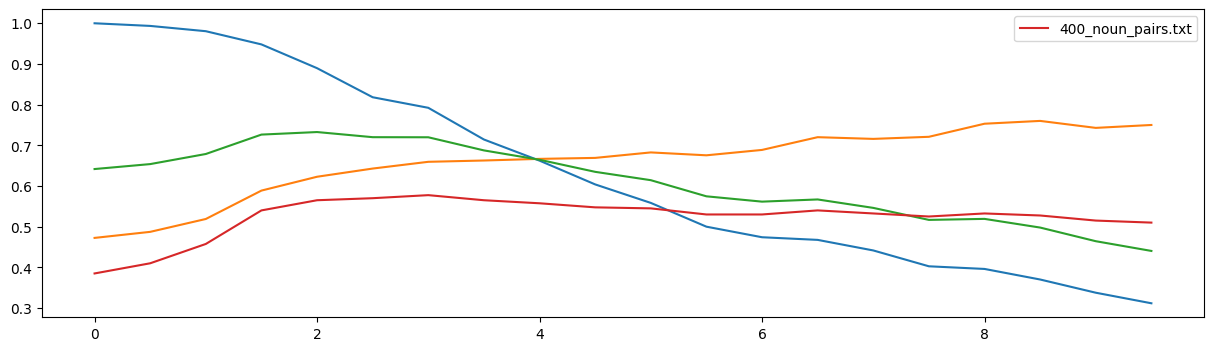

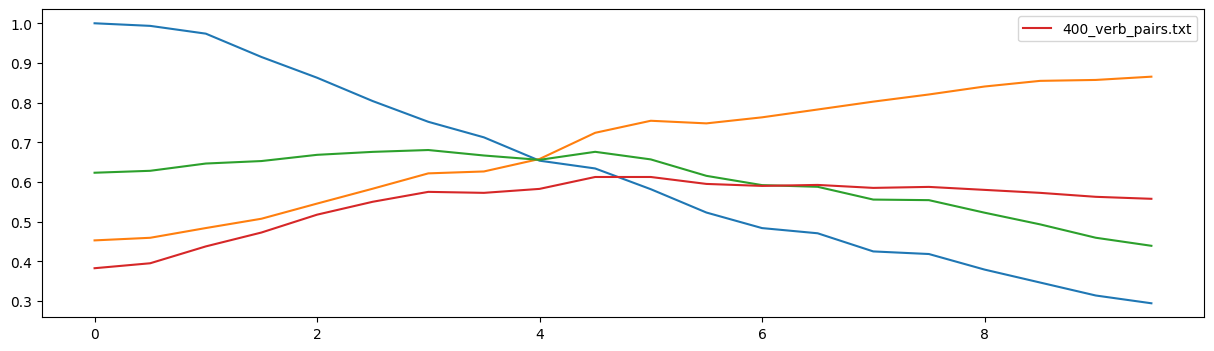

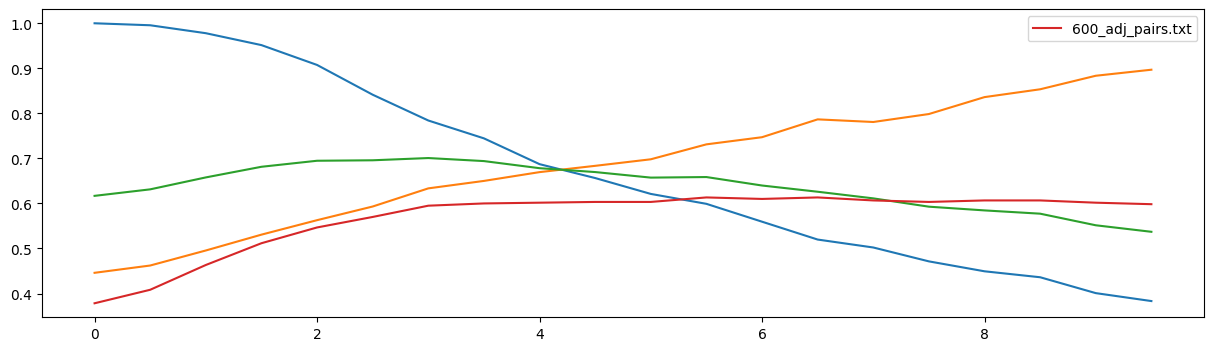

In [42]:
def test_weights(path):
    datum = []
    for i in range(0,100,5):
        w = i/10
        data = {}
        data['weight'] = w
        grid = GridSearchCV(
            estimator=LogisticRegression(max_iter=1000),
            param_grid = {'class_weight':[{0:w,1:1}]},
            cv = 10,
            n_jobs = -1,
            return_train_score=True,
        )
        grid.fit(X_train,y_train)
        df = pd.read_csv(path,sep='\t')
        y_test = []
        y_pred = []
        for rel in df["Relation"].values:
            y_test.append(1 if rel == "SYN" else 0)
        for i in range(df["Relation"].__len__()):
            y_pred.append(predict_model_test(df["Word1"].values[i],df["Word2"].values[i], grid))
        data['precision_score'] = precision_score(y_pred, y_test)
        data['recall_score'] = recall_score(y_pred, y_test)
        data['f1_score'] = f1_score(y_pred, y_test)
        data['accuracy_score'] = accuracy_score(y_pred, y_test)
        datum.append(data)
    plt.figure(figsize=(15,4))
    plt.plot([data['weight'] for data in datum],[[data['recall_score'],data['precision_score'],data['f1_score']] for data in datum])
    plt.plot([data['weight'] for data in datum],[[data['accuracy_score']] for data in datum], label = str(path)[12:])
    plt.legend()

for path in file_paths:
    test_weights(path)
